# Linear Regression Consulting Project

Congratulations! You've been contracted by Hyundai Heavy Industries to help them build a predictive model for some ships. [Hyundai Heavy Industries](http://www.hyundai.eu/en) is one of the world's largest ship manufacturing companies and builds cruise liners.

You've been flown to their headquarters in Ulsan, South Korea to help them give accurate estimates of how many crew members a ship will require.

They are currently building new ships for some customers and want you to create a model and use it to predict how many crew members the ships will need.

Here is what the data looks like so far:

    Description: Measurements of ship size, capacity, crew, and age for 158 cruise
    ships.


    Variables/Columns
    Ship Name     1-20
    Cruise Line   21-40
    Age (as of 2013)   46-48
    Tonnage (1000s of tons)   50-56
    passengers (100s)   58-64
    Length (100s of feet)  66-72
    Cabins  (100s)   74-80
    Passenger Density   82-88
    Crew  (100s)   90-96
    
It is saved in a csv file for you called "cruise_ship_info.csv". Your job is to create a regression model that will help predict how many crew members will be needed for future ships. The client also mentioned that they have found that particular cruise lines will differ in acceptable crew counts, so it is most likely an important feature to include in your analysis! 

Once you've created the model and tested it for a quick check on how well you can expect it to perform, make sure you take a look at why it performs so well!

In [1]:
from pyspark.sql import SparkSession

In [2]:
spark = SparkSession.builder.appName('LR').getOrCreate()

In [3]:
df = spark.read.csv('cruise_ship_info.csv', header=True, inferSchema=True)

In [4]:
df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
Ship_name,158,Infinity,None,Adventure,Zuiderdam
Cruise_line,158,None,None,Azamara,Windstar
Age,158,15.689873417721518,7.615691058751413,4,48
Tonnage,158,71.28467088607599,37.229540025907866,2.329,220.0
passengers,158,18.45740506329114,9.677094775143416,0.66,54.0
length,158,8.130632911392404,1.793473548054825,2.79,11.82
cabins,158,8.830000000000005,4.4714172221480615,0.33,27.0
passenger_density,158,39.90094936708861,8.63921711391542,17.7,71.43
crew,158,7.794177215189873,3.503486564627034,0.59,21.0


In [5]:
df.select('Cruise_line').distinct().show()

+-----------------+
|      Cruise_line|
+-----------------+
|            Costa|
|              P&O|
|           Cunard|
|Regent_Seven_Seas|
|              MSC|
|         Carnival|
|          Crystal|
|           Orient|
|         Princess|
|        Silversea|
|         Seabourn|
| Holland_American|
|         Windstar|
|           Disney|
|        Norwegian|
|          Oceania|
|          Azamara|
|        Celebrity|
|             Star|
|  Royal_Caribbean|
+-----------------+



In [6]:
df = df.withColumnRenamed("crew","label")

In [28]:
# from pyspark.ml.feature import StringIndexer
# from pyspark.ml.feature import OneHotEncoder
# from pyspark.ml.linalg import Vectors
# from pyspark.ml.feature import VectorAssembler
# from pyspark.ml.regression import LinearRegression
# from pyspark.ml import Pipeline

# # Rename crew to label

# indexer = StringIndexer().setInputCol("Cruise_line").setOutputCol("Cruise_line_indexed")
# encoder = OneHotEncoder(inputCols=["Cruise_line_indexed"], outputCols=["Cruise_line_vec"])

# assembler = VectorAssembler(
#     inputCols=[  'Age',
#                  'Tonnage',
#                  'passengers',
#                  'length',
#                  'cabins',
#                  'passenger_density',
#                  'Cruise_line_vec'],
#     outputCol="features")

# lr = LinearRegression(maxIter=100)

# pipeline = Pipeline(stages = [indexer,
#                               encoder,
#                               assembler,
#                               lr])

In [33]:
from pyspark.ml.feature import StringIndexer

indexer = StringIndexer().setInputCol("Cruise_line").setOutputCol("Cruise_line_indexed")

indexed_df = indexer.fit(df).transform(df)

In [34]:
indexed_df.show()

+-----------+-----------+---+------------------+----------+------+------+-----------------+-----+-------------------+
|  Ship_name|Cruise_line|Age|           Tonnage|passengers|length|cabins|passenger_density|label|Cruise_line_indexed|
+-----------+-----------+---+------------------+----------+------+------+-----------------+-----+-------------------+
|    Journey|    Azamara|  6|30.276999999999997|      6.94|  5.94|  3.55|            42.64| 3.55|               16.0|
|      Quest|    Azamara|  6|30.276999999999997|      6.94|  5.94|  3.55|            42.64| 3.55|               16.0|
|Celebration|   Carnival| 26|            47.262|     14.86|  7.22|  7.43|             31.8|  6.7|                1.0|
|   Conquest|   Carnival| 11|             110.0|     29.74|  9.53| 14.88|            36.99| 19.1|                1.0|
|    Destiny|   Carnival| 17|           101.353|     26.42|  8.92| 13.21|            38.36| 10.0|                1.0|
|    Ecstasy|   Carnival| 22|            70.367|     20.

In [35]:
# from pyspark.ml.feature import OneHotEncoder

# encoder = OneHotEncoder(inputCols=["Cruise_line_indexed"],
#                         outputCols=["Cruise_line_vec"])

# encoder = encoder.fit(indexed_df)
# encoded_df = encoder.transform(indexed_df)

In [36]:
# encoded_df.select("Cruise_line_vec","Cruise_line_indexed","Cruise_line").show(20)

In [38]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=[  'Age',
                 'Tonnage',
                 'passengers',
                 'length',
                 'cabins',
                 'passenger_density',
                 'Cruise_line_indexed'],
    outputCol="features")

output_data = assembler.transform(indexed_df)

# Grid search

In [39]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit

lr = LinearRegression(maxIter=100)

paramGrid = ParamGridBuilder()\
    .addGrid(lr.regParam, [0.2, 0.1, 0.05, 0.01]) \
    .addGrid(lr.fitIntercept, [False, True])\
    .addGrid(lr.elasticNetParam, [0.0, 0.3, 0.5, 1.0])\
    .build()

tvs = TrainValidationSplit(estimator=lr,
                           estimatorParamMaps=paramGrid,
                           evaluator=RegressionEvaluator(),
                           trainRatio=0.8
                           )

model = tvs.fit(output_data)

In [40]:
from operator import itemgetter
print("Position of best model")
print(min(enumerate(model.validationMetrics), key=itemgetter(1))[0])
print("")
print("RMSE of best model")
print(min(enumerate(model.validationMetrics), key=itemgetter(1))[1])

Position of best model
4

RMSE of best model
0.7050499571549755


In [42]:
model.getEstimatorParamMaps()[4]

{Param(parent='LinearRegression_5f674c8ffc51', name='regParam', doc='regularization parameter (>= 0).'): 0.2,
 Param(parent='LinearRegression_5f674c8ffc51', name='fitIntercept', doc='whether to fit an intercept term.'): True,
 Param(parent='LinearRegression_5f674c8ffc51', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0}

# Final model

In [103]:
lr = LinearRegression(maxIter=100, regParam=0.2 ,fitIntercept=True ,elasticNetParam=0)

In [104]:
train, test = output.randomSplit([0.8, 0.2],seed=100)

In [105]:
lr = lr.fit(output_data)

In [106]:
test_results = lr.evaluate(test)

# Evaluation 

In [107]:
print("RMSE: {}".format(test_results.rootMeanSquaredError))
print("MSE: {}".format(test_results.meanSquaredError))
print("R2: {}".format(test_results.r2))

RMSE: 0.8088686023660219
MSE: 0.6542684158935616
R2: 0.9330206597201431


In [108]:
print("Coefficients: {} Intercept: {}".format(lr.coefficients,lr.intercept))

Coefficients: [-0.008596258127006014,0.01779197795057329,0.02655003848411772,0.4180372233204593,0.38561105014502917,0.0001127232056254072,0.024852619197018335] Intercept: -0.7634752786819762


In [109]:
predictions = test_results.predictions.toPandas()

In [110]:
residuals = predictions["label"] - predictions["prediction"]

<AxesSubplot:ylabel='Count'>

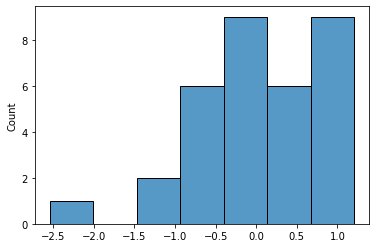

In [111]:
import seaborn as sns

sns.histplot(residuals)

<AxesSubplot:xlabel='label', ylabel='prediction'>

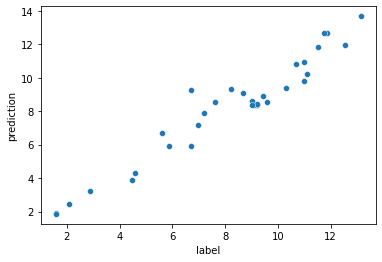

In [112]:
sns.scatterplot(x=predictions["label"], y=predictions["prediction"])